In [51]:
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
import time
import random
import numpy as np
import statistics

In [52]:

def relu(x):
	return max(0.0, x)

def relu_(x):
  if x > 0:
    return 1
  else:
    return 0


def sig(x):
 return 1/(1 + np.exp(-x))

def sig_(x):
  return sig(x)*(1-sig(x))

In [53]:
# f(x)
def f_x(weight_v, weight_w, x, k):
  phi = [[0] for i in range(k)]
  x_T = np.array(x).T
  w = []
  v = []
  # calculate phi
  for j in range(k):
    temp = weight_w[j]
    w.append(temp)
    w_mul_x_T = np.array(w).dot(np.array(x_T))
    # relu
    phi[j][0] = sig(w_mul_x_T[0])
    w = []
  v.append(weight_v)
  v_mul_phi = np.array(v).dot(np.array(phi))
  v = []
  if sig(v_mul_phi[0]) > 0.5:
    y = 1
  else:
    y = 0
  return y

# f(x)'
def f_x_(weight_v, weight_w, x, k):
  phi = [[0] for i in range(k)]
  x_T = np.array(x).T
  w = []
  # calculate phi
  for j in range(k):
    temp = weight_w[j]
    w.append(temp)
    w_mul_x_T = np.array(w).dot(np.array(x_T))
    phi[j][0] = sig_(w_mul_x_T[0])
    w = []
  v = weight_v

  output = [[0] for b in range(k)]
  for a in range(k):
    output[a][0] = v[a][0] * phi[a][0]

  return output


In [54]:
# accuracy
def ac(weight_v, weight_w, flat_test_data, Y_test, k):
  accurate = 0
  for i in range(n_test):
    predict = f_x(weight_v, weight_w, flat_test_data[i], k)
    if predict == Y_test[i][0]:
      accurate += 1
  accuracy = accurate/10000
  return accuracy

In [55]:
def ac_train(weight_v, weight_w, dataset, Y, k):
  accurate = 0
  for i in range(n_train):
    predict = f_x(weight_v, weight_w, flat_train_data[i], k)
    if predict == Y[i][0]:
      accurate += 1
  accuracy = accurate/n_train
  return accuracy

In [56]:
# calculate gradient of weight w
def g_W(weight_w, l, weight_v, x, y, k):
  v = []
  g = [[0 for i in range(785)] for j in range(k)]
  f = f_x(weight_v, weight_w, x, k)
  temp1 = l*(f - y)
  v.append(weight_v)
  # make v_t (5x1) size matrix
  v_T = np.array(v).T
  # f_x_ is (5x1) matrix
  temp2 = f_x_(v_T, weight_w, x, k)
  temp3 = temp1*np.array(temp2)
  x_temp = []
  x_temp.append(x)
  g = np.array(temp3).dot(x_temp)

  return g

# calculate gradient of weight v
def g_v(weight_w, l, weight_v, x, y, k):
  temp1 = l*f_x(weight_v, weight_w, x, k)
  phi = [[0] for i in range(k)]
  x_T = np.array(x).T
  w = []
  # calculate phi
  for j in range(k):
    temp = weight_w[j]
    w.append(temp)
    w_mul_x_T = np.array(w).dot(np.array(x_T))
    # relu
    phi[j][0] = sig(w_mul_x_T[0])
    w = []
  g = temp1*np.array(phi)

  return g

In [57]:
## MNIST dataset(images and labels)
#use ToTensor() transform to convert images into Pytorch tensors.
train_data = MNIST(root = 'data/', train = True, download = True, transform = transforms.ToTensor())
test_data = MNIST(root = 'data/', train = False, download = True, transform = transforms.ToTensor())


n_train = 50000
n_test = 10000

# formatting training data
flat_train_data = [[0] for i in range(n_train)]
train_data_label = [0 for i in range(n_train)]
for i in range(n_train):
  #temp = random.randrange(60000)
  image_tensor, label = train_data[i]
  flat_train_data[i] = image_tensor[:,0:28,0:28].flatten().tolist()
  #flat_train_data[i].append(label)
  train_data_label[i] = label

# formatting testing data
flat_test_data = [[0] for i in range(n_test)]
test_data_label = [0 for i in range(n_test)]
for i in range(n_test):
    image_tensor, label = test_data[i]
    flat_test_data[i] = image_tensor[:,0:28,0:28].flatten().tolist()
    test_data_label[i] = label

In [58]:
# z-normalization

# mean across the training data
mean = np.mean(np.array(flat_train_data))
# standard deviation across the training data
std = np.std(np.array(flat_train_data))

# standardize training data by x = (x-mean)/std
for i in range(n_train):
  temp = np.array(flat_train_data[i])
  flat_train_data[i] = np.divide(np.subtract(temp, mean), std)
# standardize testing data by x = (x-mean)/std
for i in range(n_test):
  temp = np.array(flat_test_data[i])
  flat_test_data[i] = np.divide(np.subtract(temp, mean), std)

# Add bias variable by concatenating 1
# make the dimension d=785 for each input x
for i in range(n_train):
  flat_train_data[i] = np.append(flat_train_data[i], 1)
for i in range(n_test):
  flat_test_data[i] = np.append(flat_test_data[i], 1)

In [59]:
# initialize Y in binary
Y = [[0] for j in range(n_train)]
for i in range(n_train):
	#Y[i][train_data_label[i]] = 1
  if train_data_label[i] >= 5:
    Y[i][0] = 1
  else:
    Y[i][0] = 0

# convert label of test data to binary
Y_test = [[0] for j in range(n_test)]
for i in range(n_test):
  if test_data_label[i] >= 5:
    Y_test[i][0] = 1
  else:
    Y_test[i][0] = 0

In [60]:
# shuffle data for sgd
def shuffle_data(flat_train_data, Y):
  temp = [[0 for i in range(786)] for j in range(n_train)]
  for i in range(n_train):
    temp[i] = np.append(flat_train_data[i], Y[i])

  np.random.shuffle(temp)
  train_data = [[0 for i in range(785)] for j in range(n_train)]
  train_data_label = [0 for i in range(n_train)]
  for i in range(n_train):
    train_data[i] = temp[i][0:785]
    train_data_label[i] = temp[i][-1]

  return train_data, train_data_label

In [72]:
# initialize v, w with gaussian distribution
d = 785
k = 5
# W: R_k*d
W0 = [[0 for i in range(d)] for j in range(k)]
for i in range(k):
  for j in range(d):
    temp = random.gauss(0, 1/d)
    W0[i][j] = temp
# v: R_k
v0 = [0 for i in range(k)]
for i in range(k):
  temp = random.gauss(0, 1/k)
  v0[i] = temp

In [73]:
# sgd

#learning rate
l = 0.00001
#l = 0.5
k = 5
b = 10
v = v0
w = W0
count = 0
p = []
p_train = []
ip = []

for epoch in range(10):
  print("epoch is {epoch}".format(epoch = epoch))
  train_data, train_data_label = shuffle_data(flat_train_data, Y)
  index = 0
  for iter in range(5000):
    count += 1
    if count % 1000 == 0:
      accuracy = ac(v, w, flat_test_data, Y_test, k)
      accuracy_train = ac_train(v, w, train_data, Y, k)
      print("iteration is {iter}".format(iter = iter))
      print("accuracy is {accuracy}".format(accuracy = accuracy))
      print("training accuracy is {accuracy}".format(accuracy = accuracy_train))
      p.append(accuracy)
      p_train.append(accuracy_train)
      ip.append(count)
    total_gw = 0
    total_gv = 0
    for batch in range(b):
      # calculate gradient g
      index += 1
      if index == 5000:
        index = 0
      x = train_data[index]
      y = train_data_label[index]
      total_gw += g_W(w, l, v, x, y, k)
      total_gv += g_v(w, l, v, x, y, k)
    Gw = total_gw/b
    Gv = total_gv/b
    w -= Gw
    a = np.array(Gv).T[0]
    v -= a

epoch is 0
iteration is 999
accuracy is 0.5139
training accuracy is 0.51076
iteration is 1999
accuracy is 0.5415
training accuracy is 0.53684
iteration is 2999
accuracy is 0.5976
training accuracy is 0.5782
iteration is 3999
accuracy is 0.6119
training accuracy is 0.5957
iteration is 4999
accuracy is 0.6236
training accuracy is 0.6062
epoch is 1
iteration is 999
accuracy is 0.6328
training accuracy is 0.6139
iteration is 1999
accuracy is 0.6395
training accuracy is 0.62052
iteration is 2999
accuracy is 0.6463
training accuracy is 0.62648
iteration is 3999
accuracy is 0.6507
training accuracy is 0.63096
iteration is 4999
accuracy is 0.655
training accuracy is 0.6351
epoch is 2
iteration is 999
accuracy is 0.6585
training accuracy is 0.64056
iteration is 1999
accuracy is 0.6623
training accuracy is 0.64356
iteration is 2999
accuracy is 0.6649
training accuracy is 0.6464
iteration is 3999
accuracy is 0.6674
training accuracy is 0.64852
iteration is 4999
accuracy is 0.6689
training accurac

NameError: ignored

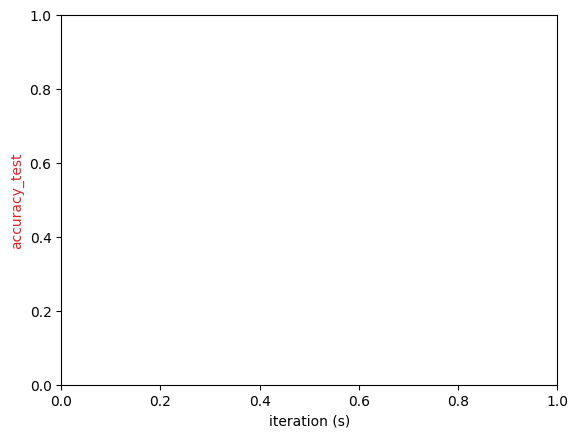

In [2]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration (s)')
ax1.set_ylabel('accuracy_test', color=color)
#plt.ylabel('accuracy')
#plt.xlabel('iteration')
ax1.plot(ip, p, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('acuracy_train', color=color)  # we already handled the x-label with ax1
ax2.plot(ip, p_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()